# Figure 1

In [13]:
import fractions
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from fooof.plts.spectra import plot_spectrum
from fooof.sim.gen import gen_aperiodic

from fooof_modified_MG import FOOOF, plot_annotated_peak_search_MG
from helper import irasa
from functions import osc_signals

try:
    from tqdm import trange
except ImportError:
    trange = range

## Parameters

In [15]:
# Signal params
srate = 2400  # Hz
win_sec = 2  # seconds
welch_params_f = dict(fs=srate, nperseg=srate)
welch_params_I = dict(fs=srate, nperseg=win_sec*srate)

# Save Path
fig_path = "../paper_figures/"
fig_name = "Fig1_Intro"
Path(fig_path).mkdir(parents=True, exist_ok=True)


# Colors

# a)
c_sim = "k"
c_ap = "#ff7f00"
c_osc = "#4daf4a"
c_fit = "#377eb8"

# Boxes
grey = .9
c_inp = (grey, grey, grey)
c_alg = (grey, grey, grey)
c_out = (grey, grey, grey)

c_inp_dark = "k"
c_alg_dark = "k"
c_out_dark = "k"

# Algorithm
c_h1 = "c"
c_h2 = "y"
c_h3 = "#984ea3"

c_tresh = "#999999"
c_flat = "#f781bf"  # pink


ls_box = (0, (5, 7))
ls_box = "-"
lw_box = 0
alpha_box = .6

lw = 2
lw_fit = 2
lw_ap = 3
ls_fit = (0, (3, 3))
lw_IR = 1
lw_PSD = 1
lw_fooof = 1.5
lw_osc = 2
lw_median = .1


In [5]:
# %% Make signal
toy_slope = 1
freq1 = 10  # Hz
freq2 = 25  # Hz
amp1 = .02
width = .001

periodic_params = [(freq1, amp1, width)]

# Sim Toy Signal
toy_aperiodic, toy_comb = osc_signals(toy_slope,
                                      periodic_params=periodic_params,
                                      highpass=False)

toy_aperiodic, toy_comb = toy_aperiodic*1e6, toy_comb*1e6

freqs_f, psd_comb_f = sig.welch(toy_comb, **welch_params_f)
freqs_I, psd_comb_I = sig.welch(toy_comb, **welch_params_I)

# Filter 1-100Hz
mask_f = (freqs_f <= 30) & (freqs_f >= 3)
freqs_f = freqs_f[mask_f]
psd_comb_f = psd_comb_f[mask_f]

mask_I = (freqs_I <= 30) & (freqs_I >= 3)
freqs_I = freqs_I[mask_I]
psd_comb_I = psd_comb_I[mask_I]

# %% Create dummy signal for illustration
time = np.arange(0, len(toy_comb)/srate, 1/srate)

time_series = np.sin(2 * np.pi * 10 * time)
# Add 1/f
time_series += .01 * toy_aperiodic


In [6]:

# %% Calc fooof

# Set whether to plot in log-log space
plt_log = True
freq_range = (1, 100)

fm = FOOOF(max_n_peaks=1)  # use default settings
fm.add_data(freqs_f, psd_comb_f, freq_range)

# Fit the power spectrum model
fm.fit(freqs_f, psd_comb_f, freq_range)

# Do an initial aperiodic fit - a robust fit, that excludes outliers
init_ap_fit = gen_aperiodic(fm.freqs,
                            fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

# Recompute the flattened spectrum using the initial aperiodic fit
init_flat_spec = fm.power_spectrum - init_ap_fit
init_flat_spec_lin = 10**fm.power_spectrum - 10**init_ap_fit



FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



In [7]:

# %% Calc IRASA
# hset = np.arange(1.1, 1.95, 0.05)
hset = np.array([1.3, 1.6, 2])
hset_inv = 1 / hset

irasa_params = dict(sf=srate, band=freq_range,
                    win_sec=win_sec, hset=hset)

IRASA = irasa(data=toy_comb, **irasa_params)

freqs_irasa, psd_ap, psd_osc, params = IRASA

psd_ap, psd_osc = psd_ap[0], psd_osc[0]

IR_offset = params["Intercept"][0]
IR_slope = -params["Slope"][0]

psd_fit = gen_aperiodic(freqs_irasa, (IR_offset, IR_slope))


win = welch_params_I["nperseg"]
psds_resampled = np.zeros((len(hset), *psd_comb_I.shape))
psds_up = np.zeros((len(hset), *psd_comb_I.shape))
psds_dw = np.zeros((len(hset), *psd_comb_I.shape))

for i, h in enumerate(hset):
    # Get the upsampling/downsampling (h, 1/h) factors as integer
    rat = fractions.Fraction(str(h))
    up, down = rat.numerator, rat.denominator
    # Much faster than FFT-based resampling
    data_up = sig.resample_poly(toy_comb, up, down)
    data_down = sig.resample_poly(toy_comb, down, up, axis=-1)

    freqs_up, psd_up = sig.welch(data_up, h * srate, nperseg=win)
    freqs_dw, psd_dw = sig.welch(data_down, srate / h, nperseg=win)

    psds_up[i, :] = psd_up[mask_I]
    psds_dw[i, :] = psd_dw[mask_I]

    # geometric mean:
    psds_resampled[i, :] = np.sqrt(psd_up * psd_dw)[mask_I]

# Now we take the median PSD of all the resampling factors, which gives
# a good estimate of the aperiodic component of the PSD.
psd_median = np.median(psds_resampled, axis=0)



In [8]:

# %% Plot Params

fig_width = 6.85  # inches
panel_fontsize = 7
legend_fontsize = 5

mpl.rcParams['font.size'] = panel_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True


yticks = [10, 100, 1000]
yticks_small = [1, 5]
yticks_lin = [0, 1000, 2000]
yticks_lin_f = [0, .5]
ylim_lin_f = [-.1, 1]

yticks_lin_I = [0, 1000, 2000]
ylim_lin_I = [-100, yticks_lin_I[-1]]


def input_series(ax, duration=1, step=srate//100):
    mask = [(time >= duration) & (time <= 2*duration)]
    ax.plot(time[mask][::step], time_series[mask][::step], c_sim, lw=lw_PSD,
            label="Signal")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.axis("off")


def input_psd(ax):
    ax.loglog(freqs_f, psd_comb_f, c_sim, lw=lw_PSD, label="PSD")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.set_yticklabels([], minor=True)
    ax.set_xticklabels([], minor=True)
    ax.axis("off")


def fooof_1(ax, ybottom=1):
    plot_spectrum(fm.freqs, 10**fm.power_spectrum, log_freqs=False,
                  lw=lw_fooof,
                  color=c_sim, ax=ax)
    plot_spectrum(fm.freqs, 10**init_ap_fit, log_freqs=False,
                  label='Initial Fit',
                  color=c_fit, lw=lw_fit, alpha=1, ls=ls_fit, ax=ax)
    ax.grid(False)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin/ybottom, ymax))
    ax.axis("off")
    leg = ax.legend(handlelength=2, handletextpad=.5, loc="lower center",
                    frameon=False)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1.5)
        legobj.set_linestyle((.6, (3, 2)))


def fooof_2(ax, yscale=1.5, ybottom=1):
    plot_spectrum(fm.freqs, init_flat_spec, log_freqs=False,
                  label='Flattened PSD', lw=lw_fooof, color=c_flat, ax=ax)
    ax.set_xscale("log")
    ax.grid(False)
    ax.axis("off")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin/ybottom, ymax))
    ymin, ymax = ax.get_ylim()
    ylim = ax.set_ylim([ymin, yscale*ymax])
    ax.get_legend().remove()
    leg = ax.legend(handlelength=1, handletextpad=.5, frameon=False,
                    loc="lower center")
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1.5)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    return ylim


def fooof_3(ax, ylim=None):
    plot_annotated_peak_search_MG(fm, 0, ax, lw=lw_fooof,
                                  markersize=10,
                                  c_flat=c_flat, c_gauss=c_osc,
                                  c_thresh=c_tresh, label_flat=None,
                                  label_rthresh=None,
                                  anno_rthresh_font=legend_fontsize)
    ax.set_xscale("log")
    ax.grid(False)

    ax.axis("off")
    if ylim:
        ax.set_ylim(ylim)
    leg = ax.legend(handlelength=1.5, frameon=False, loc=(.17, 0),
                    handletextpad=.2)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2)
        legobj.set_linestyle((0, (1, 1)))
    ax.set_title(None)


def fooof_4(ax, ylim=None, ybottom=1):
    plot_annotated_peak_search_MG(fm, 1, ax, lw=lw_fooof,
                                  markersize=10,
                                  c_flat=c_flat, c_gauss=c_osc,
                                  c_thresh=c_tresh, anno_rthresh_font=None)
    ax.set_xscale("log")
    ax.grid(False)
    ax.axis("off")
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(None)


def aperiodic(ax):
    plot_spectrum(fm.freqs, 10**fm._spectrum_peak_rm, log_freqs=False,
                  label='Aperiodic PSD', color=c_ap, lw=lw_ap, ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.set_yticklabels([], minor=True)
    ax.set_xticklabels([], minor=True)
    leg = ax.legend(handlelength=2, handletextpad=.5, frameon=False,
                    labelspacing=7.5)
    leg.legendHandles[0].set_linewidth(2)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    ax.axis("off")


def fit(ax):
    plot_spectrum(fm.freqs, 10**fm._ap_fit, log_freqs=False,
                  label='Aperiodic Fit', lw=lw_fit,
                  color=c_fit, alpha=1, ls=ls_fit, ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.set_yticklabels([], minor=True)
    ax.set_xticklabels([], minor=True)
    leg = ax.legend(handlelength=2, handletextpad=.5, frameon=False,
                    labelspacing=7.5)
    leg.legendHandles[0].set_linewidth(2)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    ax.axis("off")


def aperiodic_fit(ax, ybottom=1):
    plot_spectrum(fm.freqs, 10**fm._spectrum_peak_rm, log_freqs=False,
                  label='Aperiodic PSD', color=c_ap, lw=lw_ap, ax=ax)
    plot_spectrum(fm.freqs, 10**fm._ap_fit, log_freqs=False,
                  label='Aperiodic Fit', lw=lw_fit,
                  color=c_fit, alpha=1, ls=ls_fit, ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(False)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin/ybottom, ymax))
    leg = ax.legend(handlelength=2, handletextpad=.5, frameon=False,
                    loc="lower center")
    leg.legendHandles[0].set_linewidth(1.5)
    leg.legendHandles[1].set_linewidth(1.5)
    leg.legendHandles[1].set_linestyle((0, (2.5, 2)))
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    ax.axis("off")


def oscillatory(ax, ylim=None):
    plot_spectrum(fm.freqs, fm._peak_fit, lw=lw_osc,
                  log_freqs=False, color=c_osc,
                  label='Oscillatory PSD', ax=ax)
    ax.grid(False)
    ax.set_xscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.axis("off")
    if ylim:
        ax.set_ylim(ylim)
    ax.get_legend().remove()
    leg = ax.legend(loc=(.25, -.1), frameon=False)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))


def IRASA_res1(ax, ybottom=None, ytop=None):
    ax.loglog(freqs_I, psds_up[0], c_h1, lw=lw_IR)
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--",
              label=rf"$h={hset[0]:.1f}$")
    ax.loglog(freqs_I, psds_dw[0], c_h1, lw=lw_IR,
              label=fr"$h=\frac{{{1}}}{{{hset[0]:.1f}}}$")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_ylabel("Resampled\nPSD pairs", labelpad=-12, y=.4,
                  fontsize=legend_fontsize)
    ax.set_title(f"h={hset[0]:.1f}",
                 y=.65, fontsize=legend_fontsize)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_res2(ax, ybottom=None, ytop=None):
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--")
    ax.loglog(freqs_I, psds_up[1], c_h2, lw=lw_IR,
              label=rf"$h={hset[1]:.1f}$")
    ax.loglog(freqs_I, psds_dw[1], c_h2, lw=lw_IR,
              label=fr"$h=\frac{{{1}}}{{{hset[1]:.1f}}}$")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_title(f"h={hset[1]:.1f}",
                 y=.65, fontsize=legend_fontsize)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_res3(ax, ybottom=None, ytop=None):
    ax.loglog(freqs_I, psds_up[2], c_h3, lw=lw_IR,
              label=rf"$h={hset[2]:.0f}$")
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--")
    ax.loglog(freqs_I, psds_dw[2], c_h3, lw=lw_IR,
              label=fr"$h=\frac{{{1}}}{{{hset[2]:.0f}}}$")
    ax.set_title(f"h={hset[2]:.0f}",
                 y=.65, fontsize=legend_fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_mean1(ax, ybottom=None):
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--")
    ax.loglog(freqs_I, psds_resampled[0], c_h1, lw=lw_IR, label=f"h={hset[i]}")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(lw_median)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_ylabel("Geometric\nmean", labelpad=-12, y=.5,
                  fontsize=legend_fontsize)
    if ybottom:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((ymin/ybottom, ymax))


def IRASA_mean2(ax, ybottom=None):
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--")
    ax.loglog(freqs_I, psds_resampled[1], c_h2, lw=lw_IR, label=f"h={hset[i]}")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    if ybottom:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((ymin/ybottom, ymax))


def IRASA_mean3(ax, ybottom=None):
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--")
    ax.loglog(freqs_I, psds_resampled[2],  c_h3, lw=lw_IR,
              label=f"h={hset[i]}")
    ax.spines["right"].set_linewidth(lw_median)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ymin, ymax = ax.get_ylim()
    if ybottom:
        ax.set_ylim((ymin/ybottom, ymax))
    freq = 5
    ax.annotate(f"{freq}Hz     ",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 10
    ax.annotate(f"{freq}Hz",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 20
    ax.annotate(f"       {freq}Hz",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))


def IRASA_all(ax, ybottom=None):
    ax.loglog(freqs_I, psd_comb_I, c_sim, lw=lw_PSD, ls="--", label="h=1")
    for i, c in enumerate([c_h1, c_h2, c_h3]):
        ax.loglog(freqs_I, psds_resampled[i], c, lw=lw_IR,
                  label=f"h={hset[i]}")
    ymin, ymax = ax.get_ylim()
    freq = 5
    ax.annotate(f"{freq}Hz    ",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*1.2), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 10
    ax.annotate(f"{freq}Hz",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*1.2), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 20
    ax.annotate(f"      {freq}Hz",
                xy=(freq, psd_comb_I[freqs_I == freq][0]),
                xytext=(freq, ymin*1.2), fontsize=legend_fontsize, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    ax.axis("off")
    if ybottom:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((ymin/ybottom, ymax))


def make_frame(ax, c, title=None, **kwargs):
    ax = fig.add_subplot(ax, **kwargs)
    ax.tick_params(axis='both', which='both', bottom=0, left=0,
                   labelbottom=0, labelleft=0)
    ax.set_facecolor(c)
    ax.patch.set_alpha(alpha_box)
    ax.spines["right"].set_linestyle(ls_box)
    ax.spines["left"].set_linestyle(ls_box)
    ax.spines["top"].set_linestyle(ls_box)
    ax.spines["bottom"].set_linestyle(ls_box)
    ax.spines["right"].set_linewidth(lw_box)
    ax.spines["left"].set_linewidth(lw_box)
    ax.spines["top"].set_linewidth(lw_box)
    ax.spines["bottom"].set_linewidth(lw_box)
    if title:
        ax.set_title(title)
    return ax


arr_props = dict(facecolor='k', width=.3, headwidth=2, headlength=2, shrink=0)
arr_props_round1 = dict(facecolor='k', width=.00001, headwidth=2, headlength=2,
                        shrink=0, connectionstyle="arc3,rad=-.3")

arr_props_round2 = dict(facecolor='k', width=.00001, headwidth=1.7,
                        headlength=1.7, shrink=0,
                        connectionstyle="arc3,rad=-.3",
                        lw=.1, ls=(0, (10, 10)))



/var/folders/07/j2k588bn66nddqtk3lsg4sgr0000gp/T/ipykernel_13537/1162072518.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.plot(time[mask][::step], time_series[mask][::step], c_sim, lw=lw_PSD,


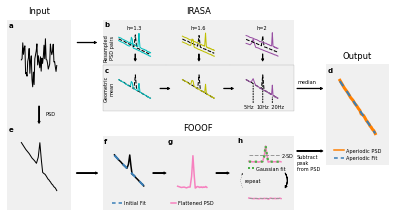

In [9]:

# %% Plot layout base

fig = plt.figure(figsize=(fig_width, 3.5))

gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1, 3, 1], wspace=.3,
                      hspace=.3, height_ratios=[5, 4])

gs_input = gs[:, 0].subgridspec(2, 1)

input_frame = make_frame(gs_input[:], c_inp, title="Input")

inp_margins = dict(xmargin=.4, ymargin=.4)
ax_inp_ser = fig.add_subplot(gs_input[0], **inp_margins)
ax_inp_PSD = fig.add_subplot(gs_input[1], **inp_margins)

# Algorithm gs
irasa_frame = make_frame(gs[0, 1], c_alg, title="IRASA")

gs_IRASA = gs[0, 1].subgridspec(2, 3, hspace=0, wspace=0)

IR_margins = dict(xmargin=.5, ymargin=.4)
gs_IR11 = fig.add_subplot(gs_IRASA[0, 0], **IR_margins)
gs_IR12 = fig.add_subplot(gs_IRASA[1, 0], **IR_margins)
gs_IR21 = fig.add_subplot(gs_IRASA[0, 1], **IR_margins)
gs_IR22 = fig.add_subplot(gs_IRASA[1, 1], **IR_margins)
gs_IR31 = fig.add_subplot(gs_IRASA[0, 2], **IR_margins)
gs_IR32 = fig.add_subplot(gs_IRASA[1, 2], **IR_margins)

gs_fooof = gs[1, 1].subgridspec(1, 2, width_ratios=[2, 1])

fooof_frame = make_frame(gs_fooof[:, :], c_alg, title="FOOOF")

gs_fooof1 = gs_fooof[0].subgridspec(1, 2, hspace=0)

fooof_margins = dict(xmargin=.4, ymargin=.6)
ax_fooof1 = fig.add_subplot(gs_fooof1[0], **fooof_margins)
ax_fooof2 = fig.add_subplot(gs_fooof1[1], **fooof_margins)

gs_fooof2 = gs_fooof[1].subgridspec(2, 1, hspace=0)

fooof_margins = dict(xmargin=.4)
ax_fooof3 = fig.add_subplot(gs_fooof2[0], **fooof_margins)
ax_fooof4 = fig.add_subplot(gs_fooof2[1], **fooof_margins)

gs_output = gs[:, 2].subgridspec(3, 1, height_ratios=[1, 3, 1])


output_frame = make_frame(gs_output[1], c_out, title="Output")

our_margins = dict(xmargin=.4, ymargin=.3)
ap = fig.add_subplot(gs_output[1], **our_margins)

# Plots
input_series(ax_inp_ser, duration=.5, step=24)
input_psd(ax_inp_PSD)

IRASA_res1(gs_IR11, ytop=.5)
IRASA_res2(gs_IR21, ytop=.5)
IRASA_res3(gs_IR31, ytop=.5)
IRASA_mean1(gs_IR12, ybottom=1.6)
IRASA_mean2(gs_IR22, ybottom=1.6)
IRASA_mean3(gs_IR32, ybottom=1.6)

fooof_1(ax_fooof1, ybottom=1.5)
ylim = fooof_2(ax_fooof2, yscale=1.0, ybottom=.9)
fooof_3(ax_fooof3, ylim)
fooof_4(ax_fooof4, ylim)

aperiodic_fit(ap, ybottom=2)

panel_dic = dict(fontweight="bold", fontsize=panel_fontsize,
                 x=.03, y=.97, va="top")

ax_inp_ser.text(s="a", transform=ax_inp_ser.transAxes, **panel_dic)
gs_IR11.text(s="b", transform=gs_IR11.transAxes, **panel_dic)
gs_IR12.text(s="c", transform=gs_IR12.transAxes, **panel_dic)
ap.text(s="d", transform=ap.transAxes, **panel_dic)
ax_inp_PSD.text(s="e", transform=ax_inp_PSD.transAxes, **panel_dic)
ax_fooof1.text(s="f", transform=ax_fooof1.transAxes, **panel_dic)
ax_fooof2.text(s="g", transform=ax_fooof2.transAxes, **panel_dic)
ax_fooof3.text(s="h", transform=ax_fooof3.transAxes, **panel_dic)

ax_inp_ser.annotate(text="", xy=(.5, -.2),
                    xytext=(.5, 0),
                    xycoords='axes fraction',
                    annotation_clip=False, arrowprops=arr_props)
ax_inp_ser.text(s="PSD", x=.6, y=-.11, transform=ax_inp_ser.transAxes,
                fontsize=legend_fontsize)


ax_fooof1.annotate(text="", xy=(-.1, .5),
                   xytext=(-.5, .5),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)


ax_fooof1.annotate(text="", xy=(1.2, .5),
                   xytext=(.95, .5),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)

ax_fooof2.annotate(text="", xy=(1.2, .5),
                   xytext=(.95, .5),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props)


ax_fooof3.annotate(text="", xy=(.85, -.4),
                   xytext=(.85, 0),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props_round1)
ax_fooof4.annotate(text="", xy=(.12, 1),
                   xytext=(.12, .6),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props_round2)
ax_fooof3.text(s="Subtract\npeak\nfrom PSD",
               x=1.05, y=.5,
               transform=ax_fooof3.transAxes,
               fontsize=legend_fontsize, va="top")
ax_fooof4.text(s="repeat", x=.15, y=.85, transform=ax_fooof4.transAxes,
               fontsize=legend_fontsize, va="top")


gs_IR11.annotate(text="", xy=(-.1, .5),
                 xytext=(-.4, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)

gs_IR11.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)

gs_IR21.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR31.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)

gs_IR12.annotate(text="", xy=(1.05, .5),
                 xytext=(.9, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR22.annotate(text="", xy=(1.05, .5),
                 xytext=(.9, .5),
                 xycoords='axes fraction',
                 annotation_clip=False, arrowprops=arr_props)

gs_IR32.annotate(text="", xy=(1.45, .5),
                 xytext=(1.05, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)

gs_IR32.text(s="median",
             x=1.05, y=.7,
             va="top",
             fontsize=legend_fontsize,
             transform=gs_IR32.transAxes)

ax_fooof3.annotate(text="", xy=(1.5, .6),
                   xytext=(1.05, .6),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)

plt.savefig(fig_path + fig_name + ".pdf", bbox_inches="tight")
plt.savefig(fig_path + fig_name + ".png", dpi=1000, bbox_inches="tight")
plt.show()
